In [142]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
from analyze_budget import analyze_multiple
import pandas as pd

In [144]:
metric = 'auc'
metric = 'final_acc'
error_type = 'sem'

what_to_plot = 'federated'
what_to_plot = 'modmod'
what_to_plot = 'data'


multicolor = what_to_plot != 'modmod'
multi_dataset=False
# multi_dataset=True

In [145]:
# analyze_multiple(fedavg_path)
# analyze_multiple('new_topology_experiment_results/jorge_setting_fedavg/comm_freq_5')
# analyze_multiple('new_topology_experiment_results/data')

In [146]:
def cal_mean_and_error(df, keys=None, metric=None,
                      error_type="sem"):
   if keys is None:
      keys = ["algo", "use_contrastive"]
   if metric is None:
      metric = "final_acc"
   keys += ["dataset"]
   m = df.groupby(keys)[
         metric].mean()
   if error_type == "sem":
      stderr = df.groupby(keys)[metric].sem()
   else:
      stderr = df.groupby(keys)[metric].std()
   df = pd.DataFrame(m).reset_index()
   df[metric + "_error"] = stderr.values
   return df

In [147]:
def normalize_by_baseline(df):
    # Create a copy of the DataFrame to avoid modifying the original data
    df_normalized = df.copy()
    
    # Identify the baseline values and errors for modular and monolithic
    baseline = df_normalized[df_normalized['algo'].str.contains('baseline')].set_index(['dataset', 'algo'])
    baseline_auc = baseline[metric]
    baseline_error = baseline[metric + '_error']

    # Function to apply normalization and error calculation
    def normalize_row(row):
        baseline_key = (row['dataset'], 'modular (baseline)' if 'modular' in row['algo'] else 'monolithic (baseline)')
        norm_value = (row[metric] - baseline_auc[baseline_key]) / baseline_auc[baseline_key]
        # norm_error = (row[metric] + row[metric + '_error'] - baseline_auc[baseline_key])  / baseline_auc[baseline_key]  # Assuming negligible error in baseline
        norm_error = row[metric + '_error'] / baseline_auc[baseline_key]  # Assuming negligible error in baseline

        return pd.Series([norm_value, norm_error], index=[metric, metric + '_error'])

    # Apply normalization and error calculation
    df_normalized[[metric, metric + '_error']] = df_normalized.apply(normalize_row, axis=1)
    return df_normalized

def map_datasets_to_new_groups(df):
    """Map original dataset names to new group names 'homo' or 'hetero'."""
    if multi_dataset:
        dataset_group_map = {
                'mnist': 'mnist', 'fashionmnist': 'fashionmnist', 'kmnist': 'kmnist',
                # 'cifar100': 'heterogeneous', 'combined': 'heterogeneous'
                'cifar100': 'cifar100', 'combined': 'combined'
            }
    else:
        dataset_group_map = {
                'mnist': 'avg', 'fashionmnist': 'avg', 'kmnist': 'avg',
                'cifar100': 'avg', 'combined': 'avg'
            }
    df['dataset'] = df['dataset'].map(dataset_group_map)
    return df

def aggregate_by_new_groups(df):
    """Aggregate DataFrame by taking the mean over new dataset groups 'homo' and 'hetero'."""
    # Group by all columns except 'value', take mean, and reset index
    group_cols = [col for col in df.columns if col != metric and col != (metric + '_error')]
    group_cols = ['dataset', 'use_contrastive', 'algo', 'topology', 'edge_drop']
    print(group_cols)
    return df.groupby(group_cols).mean().reset_index()


In [148]:
def process_topology_df(df, error_type='std'):
    regex = r'^(?P<algo>modular|monolithic)_topology_(?P<topology>[a-zA-Z_]+)_edge_drop_(?P<edge_drop>\d+\.\d+)$'


    df = df[df['use_contrastive'] == False]

    df = cal_mean_and_error(df, metric=metric, error_type=error_type)
    df[['algo', 'topology', 'edge_drop']]= df['algo'].str.extract(regex)


    # concat topology and edge_drop to `algo`

    df['algo'] = df['algo'] + '_' + df['topology'] + '_' + df['edge_drop']
    return df

In [149]:
def process_vanilla_df(df, error_type='std'):
    df = df[df['use_contrastive'] == False]
    df = cal_mean_and_error(df, metric=metric, error_type=error_type)
    df['algo'] = df['algo'].apply(lambda x: x + ' (baseline)')

    df['edge_drop'] = 0.0
    df['topology'] = 'fully_connected'
    return df

In [150]:
def process_fc_df(df, error_type='std'):
    df = df[df['use_contrastive'] == False]
    df = cal_mean_and_error(df, metric=metric, error_type=error_type)
    df['edge_drop'] = "0.0"
    df['topology'] = 'fully_connected'

    df['algo'] = df['algo'] + '_' + df['topology'] + '_' + df['edge_drop']
    return df

In [151]:
def get_fed_df():
    fedavg_path = 'new_topology_experiment_results/jorge_setting_fedavg/comm_freq_5'
    fc_fed_path = "experiment_results/jorge_setting_fedavg"

    fc_fed_df = pd.read_csv(fc_fed_path + '.csv')
    fc_fed_df = process_fc_df(fc_fed_df, error_type=error_type)
    fc_fed_df = fc_fed_df[~(fc_fed_df['dataset'].isin(['combined', 'cifar100']) & fc_fed_df['algo'].str.contains('modular_'))] 

    fed_df = pd.read_csv(fedavg_path + '.csv')
    fed_df = process_topology_df(fed_df, error_type=error_type)
    fed_df = fed_df[fed_df['topology'] != 'random']


    fed_df = fed_df[~(fed_df['dataset'].isin(['combined', 'cifar100']) & fed_df['algo'].str.contains('modular_'))]


    fedprox_path = 'topology_fedprox_results'
    fedprox_df = pd.read_csv(fedprox_path+ '.csv')
    fedprox_df = process_topology_df(fedprox_df, error_type=error_type)
    fedprox_df = fedprox_df[fedprox_df['topology'] != 'random']

    fc_fedprox_path = 'best_fl_results/fedprox_mu_0.001_comm_freq_5'
    fc_fedprox_df = pd.read_csv(fc_fedprox_path + '.csv')
    fc_fedprox_df = process_fc_df(fc_fedprox_df, error_type=error_type)
    # fc_fedprox_df = fc_fedprox_df[fc_fedprox_df['algo'].str.contains('modular') & fc_fedprox_df['dataset'].isin(['combined', 'cifar100'])]



    vanilla_df = pd.read_csv('experiment_results/vanilla_jorge_setting_basis_no_sparse.csv')
    vanilla_df = process_vanilla_df(vanilla_df, error_type=error_type)



    # df = pd.concat([fed_df, vanilla_df, fc_fed_df, fedprox_df, fc_fedprox_df])
    # df = pd.concat([fed_df, vanilla_df, fc_fed_df, fedprox_df])
    df = pd.concat([fed_df, vanilla_df, fc_fedprox_df, fedprox_df])
    return df


In [152]:
def get_data_df():
    df = pd.read_csv('new_topology_experiment_results/data.csv')
    df = process_topology_df(df, error_type=error_type)
    df = df[df['topology'] != 'random']


    fc_df = pd.read_csv('experiment_results/jorge_setting_recv.csv')
    fc_df = process_fc_df(fc_df, error_type=error_type)


    vanilla_df = pd.read_csv('experiment_results/vanilla_jorge_setting_basis_no_sparse.csv')
    vanilla_df = process_vanilla_df(vanilla_df, error_type=error_type)


    vanilla_df = vanilla_df[~((vanilla_df['algo'] == 'monolithic (baseline)') & (vanilla_df['dataset'] == 'cifar100'))]
    df.loc[(df['algo'] == 'monolithic_random_disconnect_1.0') & (df['dataset'] == 'cifar100'), 'algo'] = 'monolithic (baseline)'
    df = pd.concat([df, vanilla_df, fc_df])
    return df

In [153]:

def get_modmod_df():
    modmod_path = 'new_topology_experiment_results/modmod'
    fc_modmod_path = "experiment_results/jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True"
    fc_leep = "/home/vlongle/code/learning-hive/experiment_results/leep_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True"

    modmod_df = pd.read_csv(modmod_path+ '.csv')
    modmod_df = process_topology_df(modmod_df, error_type=error_type)
    modmod_df = modmod_df[modmod_df['topology'] != 'random']

    fc_df = pd.read_csv(fc_modmod_path + '.csv')
    fc_df = process_fc_df(fc_df, error_type=error_type)

    leep = pd.read_csv(fc_leep + '.csv')
    leep = leep[leep['dataset'] == 'combined']
    leep = process_fc_df(leep, error_type=error_type)

    vanilla_df = pd.read_csv('experiment_results/vanilla_jorge_setting_basis_no_sparse.csv')
    vanilla_df = process_vanilla_df(vanilla_df, error_type=error_type)
    
    df = pd.concat([modmod_df, vanilla_df, fc_df, leep])
    # df = pd.concat([modmod_df, vanilla_df, fc_df])
    return df

In [154]:
if what_to_plot == 'federated':
    df = get_fed_df()
elif what_to_plot == 'data':
    df = get_data_df()
else:
    df = get_modmod_df()

In [155]:
df_norm = normalize_by_baseline(df)
df_mapped = map_datasets_to_new_groups(df_norm.copy())

In [156]:
remap_name = {
    'modular_fully_connected_0.0': 'fully connected',
    'modular_random_disconnect_0.25': 'p=0.25',
    'modular_random_disconnect_0.5': 'p=0.5',
    'modular_random_disconnect_0.7': 'p=0.7',
    'modular_random_disconnect_0.9': 'p=0.9',
    'modular_ring_0.0': 'ring',
    'modular_server_0.0': 'server',
    'modular_tree_0.0': 'tree',
    'monolithic_fully_connected_0.0': 'fully connected',
    'monolithic_random_disconnect_0.25': 'p=0.25',
    'monolithic_random_disconnect_0.5': 'p=0.5',
    'monolithic_random_disconnect_0.7': 'p=0.7',
    'monolithic_random_disconnect_0.9': 'p=0.9',
    'monolithic_ring_0.0': 'ring',
    'monolithic_server_0.0': 'server',
    'monolithic_tree_0.0': 'tree'
}




In [157]:
color_map = {
    'modular_fully_connected_0.0': 'blue',
    'modular_random_disconnect_0.25': 'lightblue',
    'modular_random_disconnect_0.5': 'skyblue',
    'modular_random_disconnect_0.7': 'deepskyblue',
    'modular_random_disconnect_0.9': 'dodgerblue',
    'modular_ring_0.0': 'royalblue',
    'modular_server_0.0': 'mediumblue',
    'modular_tree_0.0': 'navy',

    'monolithic_fully_connected_0.0': 'red',
    'monolithic_random_disconnect_0.25': 'salmon',
    'monolithic_random_disconnect_0.5': 'lightcoral',
    'monolithic_random_disconnect_0.7': 'indianred',
    'monolithic_random_disconnect_0.9': 'crimson',
    'monolithic_ring_0.0': 'firebrick',
    'monolithic_server_0.0': 'darkred',
    'monolithic_tree_0.0': 'maroon',
    
}


edgecolor_map = {
    'modular_fully_connected_0.0': 'darkblue',
    'modular_random_disconnect_0.25': 'steelblue',
    'modular_random_disconnect_0.5': 'steelblue',
    'modular_random_disconnect_0.7': 'steelblue',
    'modular_random_disconnect_0.9': 'steelblue',
    'modular_ring_0.0': 'midnightblue',
    'modular_server_0.0': 'blue',
    'modular_tree_0.0': 'darkblue',
    'monolithic_fully_connected_0.0': 'darkred',
    'monolithic_random_disconnect_0.25': 'brown',
    'monolithic_random_disconnect_0.5': 'brown',
    'monolithic_random_disconnect_0.7': 'brown',
    'monolithic_random_disconnect_0.9': 'brown',
    'monolithic_ring_0.0': 'darkred',
    'monolithic_server_0.0': 'red',
    'monolithic_tree_0.0': 'darkred'
}


In [158]:
import matplotlib.pyplot as plt

# Create a color map using the CoolWarm palette
coolwarm = plt.get_cmap('coolwarm')

color_map = {
    'modular_fully_connected_0.0': coolwarm(0.0),  # Deepest blue
    'modular_random_disconnect_0.25': coolwarm(0.08),
    'modular_random_disconnect_0.5': coolwarm(0.16),
    'modular_random_disconnect_0.7': coolwarm(0.24),
    'modular_random_disconnect_0.9': coolwarm(0.32),
    'modular_ring_0.0': coolwarm(0.40),
    'modular_server_0.0': coolwarm(0.44),
    'modular_tree_0.0': coolwarm(0.48),
}

# Monolithic configurations in reds, with a consistent descending pattern
color_map.update({
    'monolithic_fully_connected_0.0': coolwarm(1.0),  # Deepest red
    'monolithic_random_disconnect_0.25': coolwarm(0.92),
    'monolithic_random_disconnect_0.5': coolwarm(0.84),
    'monolithic_random_disconnect_0.7': coolwarm(0.76),
    'monolithic_random_disconnect_0.9': coolwarm(0.68),
    'monolithic_ring_0.0': coolwarm(0.64),
    'monolithic_server_0.0': coolwarm(0.60),
    'monolithic_tree_0.0': coolwarm(0.56),
})

# Define darker variants for edge colors for better contrast
edgecolor_map = {}
for key, color in color_map.items():
    # Extract RGB values and darken them by reducing brightness
    r, g, b, a = color
    factor = 0.8  # Darken by 20%
    darker_color = (r * factor, g * factor, b * factor, a)
    edgecolor_map[key] = darker_color


In [159]:
hatch_map = {
    'modular_fully_connected_0.0': '',    # Slashes
    'modular_random_disconnect_0.25': '//', # Vertical lines
    'modular_random_disconnect_0.5': '||',  # Vertical lines
    'modular_random_disconnect_0.7': '\\', # Vertical lines
    'modular_random_disconnect_0.9': '-', # Vertical lines
    'modular_ring_0.0': 'oo',               # Circles
    'modular_server_0.0': '++',             # Crosses
    'modular_tree_0.0': 'O', # Backslashes
    'monolithic_fully_connected_0.0': '', # Slashes
    'monolithic_random_disconnect_0.25': '//', # Vertical lines
    'monolithic_random_disconnect_0.5': '||',  # Vertical lines
    'monolithic_random_disconnect_0.7': '\\', # Vertical lines
    'monolithic_random_disconnect_0.9': '-', # Vertical lines
    'monolithic_ring_0.0': 'oo',               # Circles
    'monolithic_server_0.0': '++',             # Crosses
    'monolithic_tree_0.0': 'O', # Backslashes
}


In [160]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.collections import PatchCollection


plt.style.use('seaborn-whitegrid')


# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch



def plot(df, color_map, edgecolor_map, remap_name, name='', ax=None, include_legend=True, multicolor=True):
    if ax is None:
        figsize = (15, 5)
        fig, ax = plt.subplots(figsize=figsize)

    # Plotting each bar with a different color
    legend_entries = {}
    df = df[df['algo'].isin(remap_name.keys())]
    for i, (algo, v, v_err) in enumerate(zip(df['algo'], df[metric], df[metric + '_error'])):
        bar = ax.bar(i, v, color=color_map[algo], label=remap_name[algo],
                    edgecolor=edgecolor_map[algo], yerr=v_err, width=0.8)
        label = remap_name[algo]
        if label not in legend_entries:
            legend_entries[label] = [None, None]  # [modular color, monolithic color]
        if 'modular' in algo:
            legend_entries[label][0] = color_map[algo]
        elif 'monolithic' in algo:
            legend_entries[label][1] = color_map[algo]

    metric_label = {
        'auc': 'AUC',
        'final_acc': 'Final accuracy'
    }
    metric_l = metric_label[metric]
    ax.set_xticks([])
    # ax.set_ylabel(f'{metric_l} improvement (%)', fontsize=14)
    ax.set_ylabel('Improvement (%)', fontsize=14)
    ax.set_xlabel('Topology', fontsize=14)
    ax.set_title(name, fontsize=16)

    if include_legend:
        # Create custom legend entries
        if multicolor:
            ax.legend([MulticolorPatch(c) for c in legend_entries.values()], legend_entries.keys(), handler_map={MulticolorPatch: MulticolorPatchHandler()}, frameon=True, loc='lower right', bbox_to_anchor=(1.1, 0.0))
        else:
            ax.legend( frameon=True, loc='lower right', bbox_to_anchor=(1.1, 0.0))

    ax.grid(True, which='major', linestyle='--', alpha=0.5,)

/tmp/ipykernel_3166801/4047241964.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


['dataset', 'use_contrastive', 'algo', 'topology', 'edge_drop']


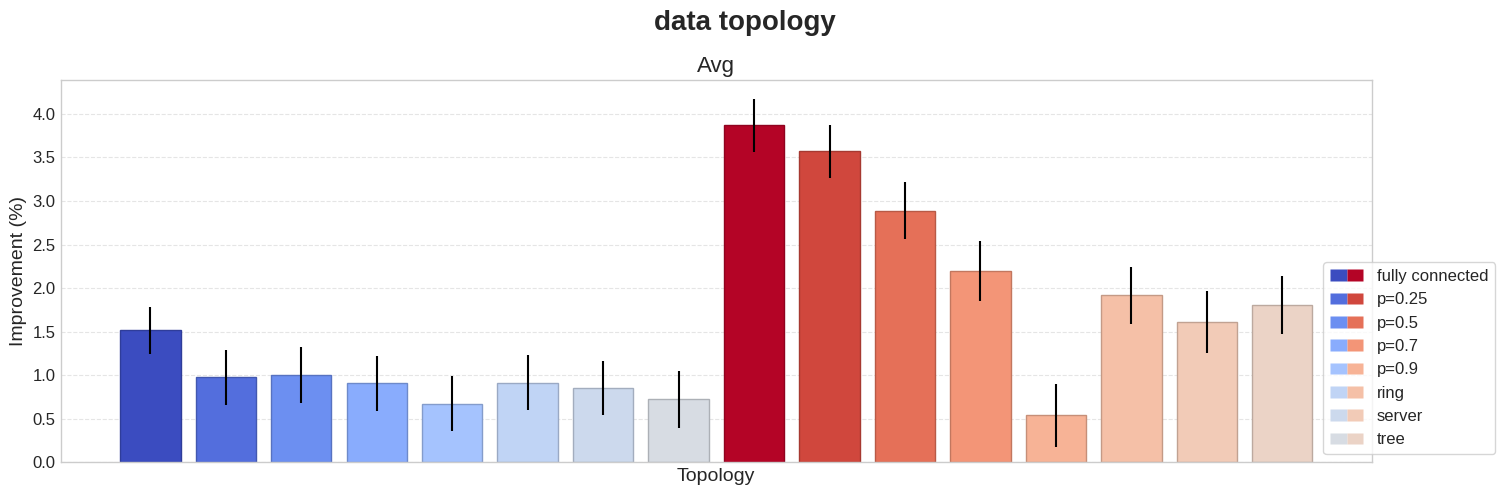

In [161]:
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    # 'font.family': 'Arial'
})

df = aggregate_by_new_groups(df_mapped)
df[metric] *= 100
df[metric + '_error'] *= 100


fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plot(df, color_map, edgecolor_map, remap_name, name='Avg', multicolor=multicolor, ax=ax)
fig.suptitle(f'{what_to_plot} topology', fontsize=20, fontweight='bold')
plt.tight_layout()
fig.savefig(f'Figures/{what_to_plot}_topology.pdf')


In [162]:
f'Figures/{what_to_plot}_topology.pdf'

'Figures/data_topology.pdf'

In [163]:
datasets = df_mapped['dataset'].unique()

if len(datasets) > 1:

    fig, ax = plt.subplots(1, len(datasets), figsize=(5 * len(datasets), 5), sharey=True)

    for i, dataset in enumerate(datasets):
        df_dataset = df_mapped[df_mapped['dataset'] == dataset]
        df_dataset = aggregate_by_new_groups(df_dataset)
        df_dataset[metric] *= 100
        df_dataset[metric + '_error'] *= 100
        plot(df_dataset, color_map, edgecolor_map, remap_name, name=dataset, multicolor=what_to_plot == 'federated', ax=ax[i], include_legend=False)

In [164]:
df_mapped[df_mapped['dataset'] == 'cifar100']

,algo,use_contrastive,dataset,final_acc,final_acc_error,topology,edge_drop
